# Importing necessary libraries 


In [1]:
import cv2
import os
import numpy as np
import datetime
from imutils.video import VideoStream
from datetime import timedelta
from tensorflow.keras.models import load_model
from openpyxl import Workbook
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

In [2]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from joblib import dump , load

# Is_Live function

In [3]:
is_live = False


def if_live(frame, prev_frame, threshold=10):
    global is_live  # Access the global variable
    
    if frame is None or prev_frame is None :
        return False,False
    
    # Blink detection (basic implementation)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_prev = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    # Thresholding to isolate foreground (face)
    thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1]
    thresh_prev = cv2.threshold(gray_prev, 127, 255, cv2.THRESH_BINARY)[1]
    
    thresh_prev_resized = cv2.resize(thresh_prev, (thresh.shape[1], thresh.shape[0]))

    # Calculate difference between current and previous frames
    difference = cv2.absdiff(thresh, thresh_prev_resized)

    # Count the number of non-zero pixels (indicating change)
    num_changed_pixels = cv2.countNonZero(difference)

    # Threshold for blink detection (adjust based on image resolution)
    blink_threshold = 500

    # Check if number of changed pixels exceeds blink threshold
    is_blink = num_changed_pixels > blink_threshold
    is_live = is_blink  

    return is_live # Return additional information for debugging


# Collect Facial Data

In [4]:

# Define paths for data collection and model storage
data_path = "face_dataset"  # Replace with your dataset path
model_path = "face_recognition_model.h5"  # Trained model output path

names = []        # Initialize an empty list to store names
if os.path.exists('face_dataset') :
    names.extend(os.listdir('face_dataset'))
        
label_encoder = LabelEncoder()


def collect_facial_data(person_name):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)  # Use 0 for default webcam

    # Create a directory for the person's data if it doesn't exist
    os.makedirs(os.path.join(data_path, person_name), exist_ok=True)
    if os.path.exists('face_dataset') :
        names.extend(os.listdir('face_dataset'))
    
    num_samples = 0

    
    while True:
        ret, frame = cap.read()
        frame = cv2.flip(frame,1)
        faces = face_cascade.detectMultiScale(frame, 1.8, 5)
    

        for (x, y, w, h) in faces:
          
            roi_color = frame[y-68:y+h+18, x-28:x+w+38]

            cv2.rectangle(frame, (x-30, y-70), (x+w+40, y+h+20), (0, 255, 0), 2)
            num_samples += 1
            cv2.imwrite(os.path.join(data_path, person_name, f"{num_samples}.jpg"), roi_color)
        
        cv2.putText(frame, f"Samples Collected: {num_samples}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow('Collecting Facial Data', frame)
        key = cv2.waitKey(1) & 0xFF
        
        # Quit on 'q' press or after collecting enough samples
        if key == ord('q') or num_samples >= 100:
            cap.release()
            cv2.destroyAllWindows()
            break
            
    # Add the new person's name to the list
    names.append(person_name)

    # Update the label encoder with the expanded list of names 
    label_encoder.fit(names)
    

# ... (other code)
label_encoder.fit(names)

# collect_facial_data('Akash')


LabelEncoder()

# Loading Images and Labels and Encoding Labels

In [5]:
# Load images and labels from data directory
images = []
labels = []
for person_name in os.listdir(data_path):
    for filename in os.listdir(os.path.join(data_path, person_name)):
        img_path = os.path.join(data_path, person_name, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (200, 200))  # Resize images for CNN input
        images.append(img)
        labels.append(person_name)

# Convert images and labels to NumPy arrays
images = np.array(images, dtype=np.float32) / 255.0
labels = np.array(labels)


# One-hot encode labels for categorical crossentropy loss   
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse_output=False)
labels = onehot_encoder.fit_transform(labels.reshape(-1, 1))


# CNN MODEL

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 570ms/step - accuracy: 0.2028 - loss: 7.6251 - val_accuracy: 0.7632 - val_loss: 1.1892
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 578ms/step - accuracy: 0.6619 - loss: 1.2958 - val_accuracy: 0.9763 - val_loss: 0.4960
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 550ms/step - accuracy: 0.7862 - loss: 0.8907 - val_accuracy: 0.9895 - val_loss: 0.3755
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 552ms/step - accuracy: 0.8244 - loss: 0.7184 - val_accuracy: 0.9895 - val_loss: 0.2811
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 548ms/step - accuracy: 0.8617 - loss: 0.5948 - val_accuracy: 1.0000 - val_loss: 0.2522
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 531ms/step - accuracy: 0.8706 - loss: 0.5794 - val_accuracy: 1.0000 - val_loss: 0.2322
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 544ms/step - accuracy: 0.8983 - loss: 0.5012 - val_accuracy: 1.0000 - val_loss: 0.2263
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 544ms/step - accuracy: 0.8983 - loss: 0.5148 - val_accu

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 200, 200, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 100, 100, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 80000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      10,240,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 17)                  │           2,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,006,709 (118.28 MB)

 Trainable params: 10,335,569 (39.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,671,140 (78.85 MB)

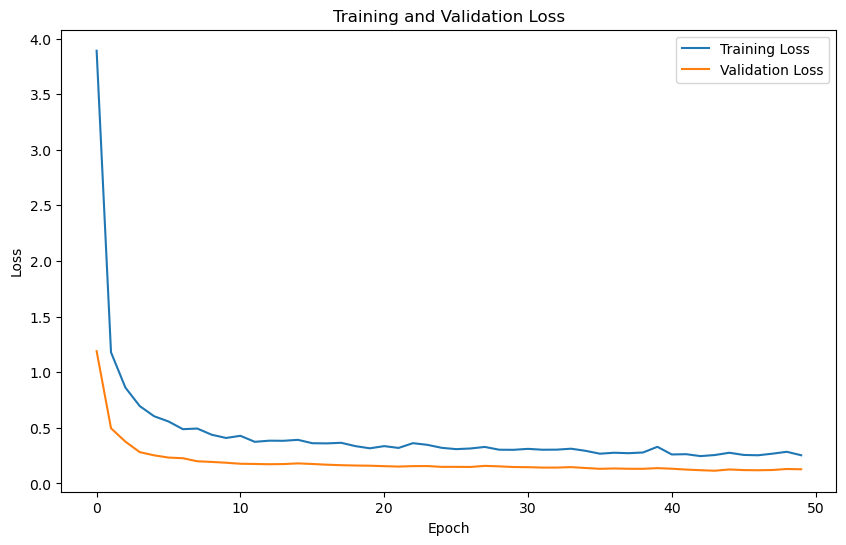

Model training complete!


In [13]:
# Function to train the CNN model
def train_cnn_model():
   
    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    
    # Build and train the CNN model
    model = Sequential()
    
    # First convolutional layer     
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same',activation='relu', kernel_initializer='he_uniform',
                     input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    #Second Convolultional layer 
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    #Third convolutional layer     
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    
    # Dropout for regularization
    model.add(Dropout(0.25))
    
    # Flatten the output of the convolutional layers
    model.add(Flatten())
    
    # Dense layers for classification
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer with num_classes

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Split data into training and validation sets (optional)
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Train the model (adjust epochs based on dataset size and computational resources)
    history=model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))  # Consider validation for overfitting
    
    
    model.summary()
    # Save the trained model
    model.save(model_path)  # Use the defined model_path
    
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Train the CNN model
train_cnn_model()

print("Model training complete!")

# CNN Model Confusion matrix


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
Confusion Matrix:


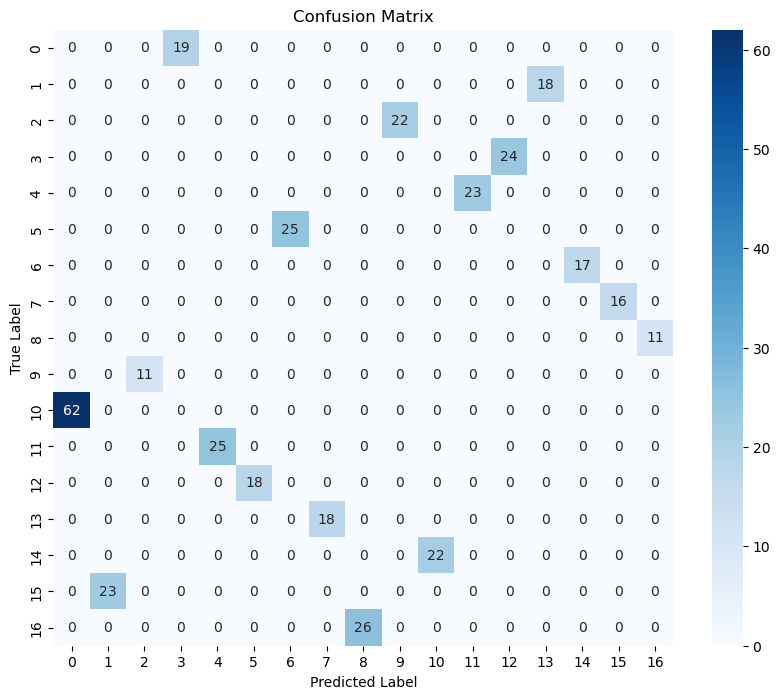

In [7]:
# Split data into training and validation sets (optional)    
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load the trained CNN model
model = load_model(model_path)
# Predict labels for validation set
y_pred = model.predict(X_val)
# Convert one-hot encoded labels to categorical labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
confusion_mat = confusion_matrix(y_val_classes, y_pred_classes)
print("Confusion Matrix:")
# print(confusion_mat)
   
    
# Visualize confusion matrix using box plot
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()    
 

# CNN Classification Report

Classification Report:
              precision    recall  f1-score   support

      Ananya       0.00      0.00      0.00      19.0
      Barkha       0.00      0.00      0.00      18.0
       Julie       0.00      0.00      0.00      22.0
     Kanchan       0.00      0.00      0.00      24.0
      Kanika       0.00      0.00      0.00      23.0
  Mahashweta       0.00      0.00      0.00      25.0
      Manshi       0.00      0.00      0.00      17.0
       Neeti       0.00      0.00      0.00      16.0
     Pallawi       0.00      0.00      0.00      11.0
      Pushpa       0.00      0.00      0.00      11.0
        Rani       0.00      0.00      0.00      62.0
      Ritika       0.00      0.00      0.00      25.0
      Saumya       0.00      0.00      0.00      18.0
      Sohini       0.00      0.00      0.00      18.0
    Yakshita       0.00      0.00      0.00      22.0
    priyanka       0.00      0.00      0.00      23.0
      shreya       0.00      0.00      0.00      26.0

   

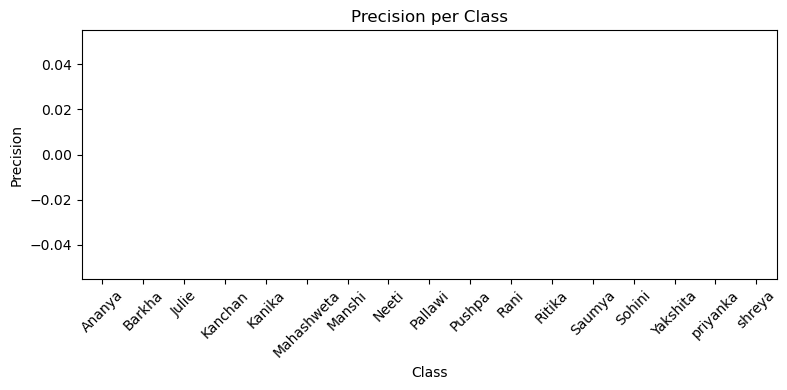

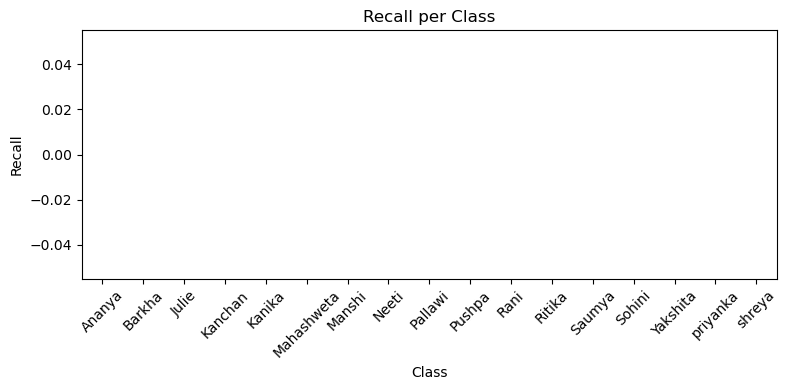

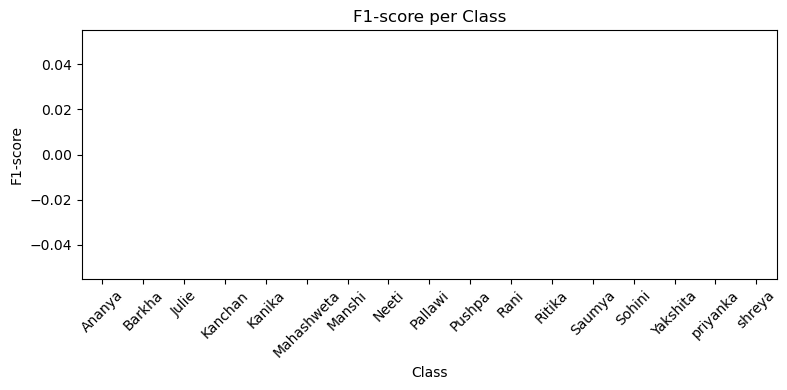

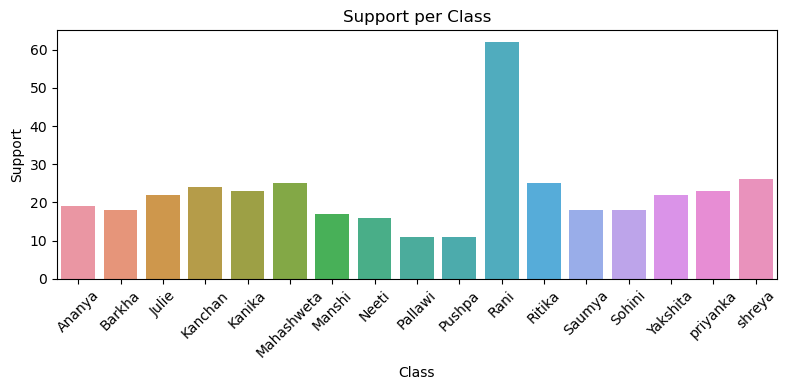

In [9]:
# Parse classification report string and extract metrics
def parse_classification_report(report):
    lines = report.split('\n')
    data = [line.split() for line in lines[2:-5]]
    classes = [line.split()[0] for line in lines[2:-5]]
    metrics = ['precision', 'recall', 'f1-score', 'support']
    df_data = []
    for d in data:
        row_data = [float(x) for x in d[1:]]
        df_data.append(row_data)
    df = pd.DataFrame(df_data, columns=metrics, index=classes)
    return df



# Compute and print classification report
class_report = classification_report(y_val_classes, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)

# Parse classification report and convert it to DataFrame
class_report_df = parse_classification_report(class_report)

# Plot metrics for each class
for metric in class_report_df.columns:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=class_report_df.index, y=class_report_df[metric])
    plt.title(f'{metric.capitalize()} per Class')
    plt.xlabel('Class')
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Mark Attendance using CNN Model

In [6]:
# Define paths and variables
data_path = "face_dataset"
model_path = "face_recognition_model.h5"
attendance_file = "attendance.xlsx"
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
recorded_names = set() # Create an empty set to store already recorded names

# Function to recognize face and mark attendance
def recognize_and_mark_attendance(model):
    # Load the trained CNN model
    model = load_model(model_path)
    global label_encoder  # Access the global label encoder
    # Load the label encoder if not already loaded
       
    # Create an Excel workbook for attendance
    wb = Workbook()
    ws = wb.active
    ws.append(["Date", "Time", "Name"])  # Header row

    # Start video stream
    vs = VideoStream(src=0).start()
    while True:
        frame = vs.read()
        faces = face_cascade.detectMultiScale(frame, 1.8, 5)
        num_samples = 0
        prev_frame = None  # Store the previous frame for comparison
        start_time = None  # Time when collection starts
        
        for (x, y, w, h) in faces:
            roi_color = frame[y-68:y+h+18, x-28:x+w+38]
            
            # Liveness detection (replace with your implementation)
            prev_frame = frame  # Assuming you have a mechanism to store the previous frame
            
            # Liveness detection (blink movement)
            global is_live
            
            
            # Check if ROI is empty before proceeding
            if roi_color is not None and roi_color.any():
                # Liveness detection (blink and head movement)
                is_live = if_live(roi_color, prev_frame)
                prev_frame = frame.copy() # Update previous frame for next iteration
            else:
                continue  # Skip this iteration if ROI is empty
                
            if is_live:
                # Reset blink count and start time if live face detected
#                 cv2.rectangle(frame, (x-30, y-70), (x+w+40, y+h+20), (0, 255, 0), 2)
                # Resize for model input
                img = cv2.resize(roi_color, (200, 200))
                img = np.expand_dims(img, axis=0)  # Add a dimension for batch processing
                img = np.array(img, dtype=np.float32) / 255.0

                # Predict probability distribution for each class (person)
                predictions = model.predict(img)[0]

                # Find the class with the highest probability
                max_index = np.argmax(predictions)
                predicted_name = label_encoder.inverse_transform([max_index])[0]
                proba = predictions[max_index]

                # Display name and confidence level if probability is high enough
                if predicted_name in recorded_names and proba > 0.8:  # Check if already recorded
                    print(f"{predicted_name} already marked attendance.") 
                    cv2.putText(frame, f"{predicted_name} ({proba:.2f})", (x-30, y - 75),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

                elif proba > 0.6:  # Adjust threshold based on your model's performance
                    cv2.putText(frame, f"{predicted_name} ({proba:.2f})", (x-30, y - 75),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                    recorded_names.add(predicted_name)
                    # Mark attendance in Excel
                    now = datetime.datetime.now()
                    ws.append([now.strftime("%Y-%m-%d"), now.strftime("%H:%M:%S"), predicted_name])

                else:
                    cv2.putText(frame, "Unknown", (x-30, y - 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

                cv2.rectangle(frame, (x-30, y-70), (x+w+20, y+h+40), (255, 0, 0), 2)
            
            
            
            else :
                cv2.putText(frame, "Not Live Face Detected", (x, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                continue
                
        cv2.imshow('Attendance System', frame)
        key = cv2.waitKey(1) & 0xFF

        # Save attendance data and quit on 'q' press
        if key == ord('q'):
            wb.save(attendance_file)
            break

    vs.stop()
    cv2.destroyAllWindows()


In [7]:
model= load_model
recognize_and_mark_attendance(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Manash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Manash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Manash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Manash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Akash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Akash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Akash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Akash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Akash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Manash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Akash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Akash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Manash already marked attend

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Akash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Akash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Manash already marked attendance.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Manash already marked atte

In [9]:
cv2.destroyAllWindows()

# SVM Model

In [12]:
def train_svm_model():

    # Split data into training and validation sets (optional)
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    
      # Create a pipeline with SVM for classification
    svm_model = make_pipeline(OneVsRestClassifier(SVC(kernel='linear')))

      # Train the SVM model
    svm_model.fit(X_train_flat, y_train)

    # Save the trained model (optional)
    # ... (use your preferred model saving method)
    dump(svm_model, 'svm_model.joblib')
    print("Model training complete!")
 
    
# Train the SVM model
train_svm_model()

Model training complete!


In [10]:
def train_svm_model3():

    # Split data into training and validation sets (optional)
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    
      # Create a pipeline with SVM for classification
    svm_model = make_pipeline(OneVsRestClassifier(SVC(kernel='rbf'))) # rbf = e^(-x^2)

      # Train the SVM model
    svm_model.fit(X_train_flat, y_train)

    # Save the trained model (optional)
    # ... (use your preferred model saving method)
    dump(svm_model, 'svm_model.joblib')
    print("Model training complete!")
 
    
# Train the SVM model
train_svm_model3()

Model training complete!


# SVM Model Confusion Matrix

Confusion Matrix:
Confusion Matrix:


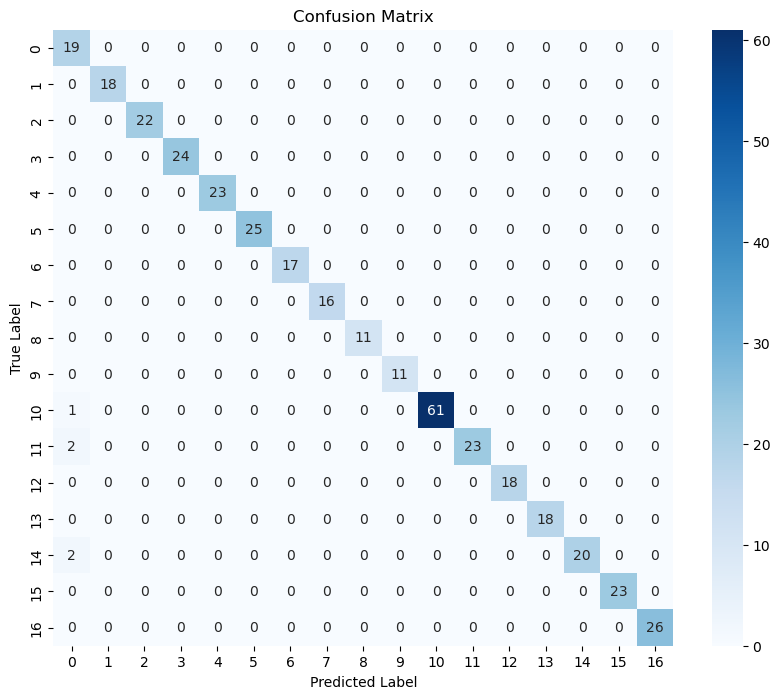

In [11]:
# Split data into training and validation sets (optional)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

svm_model = load('svm_model.joblib')


# Evaluate the model on the validation set (optional)
preds = svm_model.predict(X_val_flat)
# Convert one-hot encoded labels to categorical labels (if applicable)
y_p_classes = np.argmax(preds, axis=1)
y_val_class = np.argmax(y_val, axis=1)

print("Confusion Matrix:")

# Compute confusion matrix
confusion_mat = confusion_matrix(y_val_class, y_p_classes)
print("Confusion Matrix:")
# print(confusion_mat)
   
    
# Visualize confusion matrix using box plot
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()    
 

# SVM Model Classification Report

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        19
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        23
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        16
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00        11
          10       1.00      0.98      0.99        62
          11       1.00      0.92      0.96        25
          12       1.00      1.00      1.00        18
          13       1.00      1.00      1.00        18
          14       1.00      0.91      0.95        22
          15       1.00      1.00      1.00        23
          16       1.00      1.00      1.00        26

   

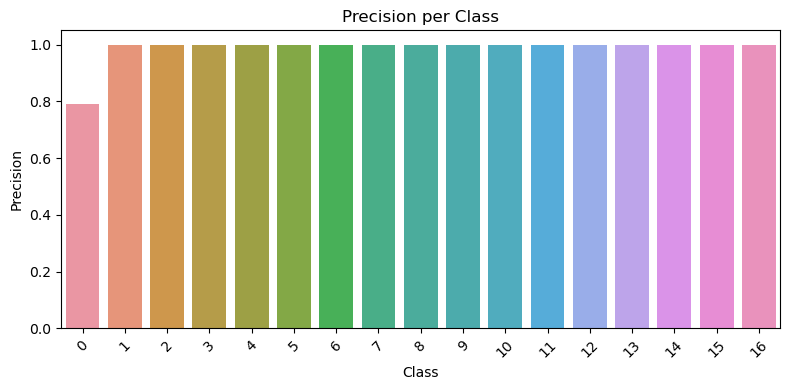

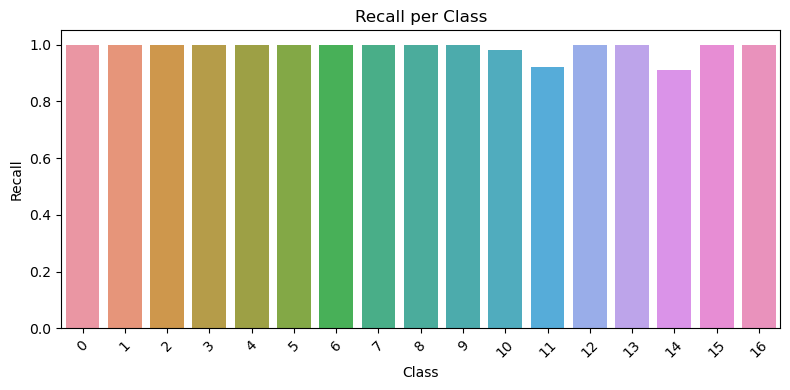

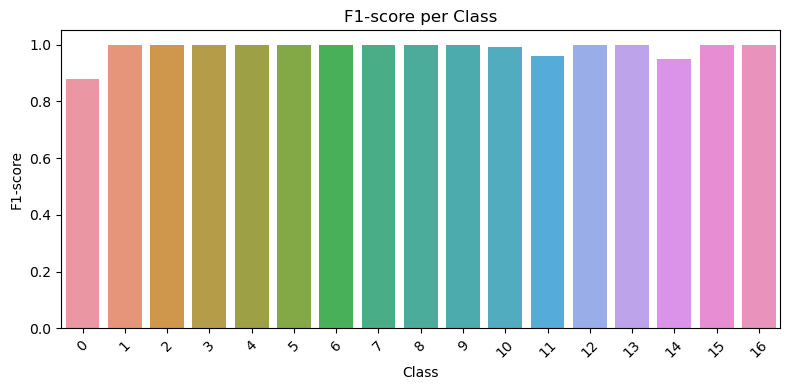

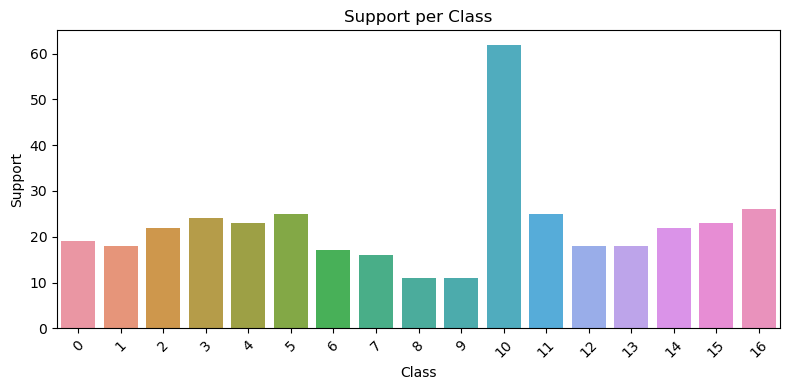

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        19
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        23
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        16
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00        11
          10       1.00      0.98      0.99        62
          11       1.00      0.92      0.96        25
          12       1.00      1.00      1.00        18
          13       1.00      1.00      1.00        18
          14       1.00      0.91      0.95        22
          15       1.00      1.00      1.00        23
          16       1.00      1.00      1.00        26

   

In [16]:
# Parse classification report string and extract metrics
def parse_classification_report(report):
    lines = report.split('\n')
    data = [line.split() for line in lines[2:-5]]
    classes = [line.split()[0] for line in lines[2:-5]]
    metrics = ['precision', 'recall', 'f1-score', 'support']
    df_data = []
    for d in data:
        row_data = [float(x) for x in d[1:]]
        df_data.append(row_data)
    df = pd.DataFrame(df_data, columns=metrics, index=classes)
    return df



# Compute and print classification report
class_report = classification_report(y_val_class, y_p_classes)
print("Classification Report:")
print(class_report)

# Parse classification report and convert it to DataFrame
class_report_df = parse_classification_report(class_report)

# Plot metrics for each class
for metric in class_report_df.columns:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=class_report_df.index, y=class_report_df[metric])
    plt.title(f'{metric.capitalize()} per Class')
    plt.xlabel('Class')
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Print classification report and confusion matrix (optional)
print("Classification Report:")
print(classification_report(y_val_class, y_p_classes))




# Mark Attendence using SVM Model

In [6]:
from sklearn.preprocessing import LabelEncoder

data_path = "face_dataset" 
s_images = []
s_labels = []
for person_name in os.listdir(data_path):
    for filename in os.listdir(os.path.join(data_path, person_name)):
        img_path = os.path.join(data_path, person_name, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (200, 200))  # Resize images for CNN input
        s_images.append(img)
        s_labels.append(person_name)

# Convert images and labels to NumPy arrays
s_images = np.array(s_images, dtype=np.float32) / 255.0
s_labels = np.array(s_labels)


# One-hot encode labels for categorical crossentropy loss   
label_encoder = LabelEncoder()
s_labels = s_labels.flatten()  # Reshape labels to a 1D array
s_labels = label_encoder.fit_transform(s_labels)
# onehot_encoder = OneHotEncoder(sparse_output=False)
# s_labels = onehot_encoder.fit_transform(s_labels.reshape(-1, 1))



# Define paths and variables

attendance_file = "attendance.xlsx"
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
recorded_names = set() # Create an empty set to store already recorded names

# Function to recognize face and mark attendance
def svm_recognize_and_mark_attendance():
    
    svm_model = load('svm_model.joblib')
    global label_encoder  # Access the global label encoder
    # Load the label encoder if not already loaded
       
    # Create an Excel workbook for attendance
    wb = Workbook()
    ws = wb.active
    ws.append(["Date", "Time", "Name"])  # Header row

    # Start video stream
    vs = VideoStream(src=0).start()
    while True:
        frame = vs.read()
        faces = face_cascade.detectMultiScale(frame, 1.8, 5)
        
        for (x, y, w, h) in faces:
            roi_color = frame[y-68:y+h+18, x-28:x+w+38]
            
            # Resize for model input
            img = cv2.resize(roi_color, (200, 200))
            img = np.expand_dims(img, axis=0)  # Add a dimension for batch processing
            img = np.array(img, dtype=np.float32) / 255.0
            # Flatten the image for SVM model
            img_flat = img.reshape(img.shape[0], -1)
            
            # Predict probability distribution for each class (person)   
            svm_predictions=svm_model.predict(img_flat)

                # Find the class with the highest probability
                
            svm_max_index=np.argmax(svm_predictions)   
            svm_predicted_name=label_encoder.inverse_transform([svm_max_index])[0]  
            svm_proba = svm_predictions[0][svm_max_index]
            print('svm predicted name ',svm_predicted_name)
            print("Shape of svm_predictions:", svm_predictions.shape)
            print("Max index:", svm_max_index)

            # Display name and confidence level if probability is high enough
            if svm_predicted_name in recorded_names and np.any(svm_proba > 0.9):  # Check if already recorded
                print(f"{svm_predicted_name} already marked attendance.") 
                cv2.putText(frame, f"{svm_predicted_name} ({svm_proba:.2f})", (x-30, y - 75),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            elif np.any(svm_proba > 0.9):  # Adjust threshold based on your model's performance
                cv2.putText(frame, f"{svm_predicted_name} ({svm_proba:.2f})", (x-30, y - 75),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                recorded_names.add(svm_predicted_name)
                # Mark attendance in Excel
                now = datetime.datetime.now()
                ws.append([now.strftime("%Y-%m-%d"), now.strftime("%H:%M:%S"), svm_predicted_name])


            else:
                cv2.putText(frame, "Unknown", (x-30, y - 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

            cv2.rectangle(frame, (x-30, y-70), (x+w+20, y+h+40), (255, 0, 0), 2)
            
                
        cv2.imshow('Attendance System', frame)
        key = cv2.waitKey(1) & 0xFF

        # Save attendance data and quit on 'q' press
        if key == ord('q'):
            wb.save(attendance_file)
            break

    vs.stop()
    cv2.destroyAllWindows()
    
    
svm_recognize_and_mark_attendance()

svm predicted name  Kundan
Shape of svm_predictions: (1, 17)
Max index: 8
svm predicted name  Akash
Shape of svm_predictions: (1, 17)
Max index: 0
svm predicted name  Akash
Shape of svm_predictions: (1, 17)
Max index: 0
svm predicted name  Akash
Shape of svm_predictions: (1, 17)
Max index: 0
Akash already marked attendance.
svm predicted name  Akash
Shape of svm_predictions: (1, 17)
Max index: 0
Akash already marked attendance.
svm predicted name  Akash
Shape of svm_predictions: (1, 17)
Max index: 0
Akash already marked attendance.
svm predicted name  Akash
Shape of svm_predictions: (1, 17)
Max index: 0
svm predicted name  Akash
Shape of svm_predictions: (1, 17)
Max index: 0
svm predicted name  Akash
Shape of svm_predictions: (1, 17)
Max index: 0
svm predicted name  Akash
Shape of svm_predictions: (1, 17)
Max index: 0
svm predicted name  Akash
Shape of svm_predictions: (1, 17)
Max index: 0
svm predicted name  Akash
Shape of svm_predictions: (1, 17)
Max index: 0
svm predicted name  Akas

# SVM Model using One vs One classification technique

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.datasets import dump_svmlight_file

def train_svm_model2():
   # Split data into training and validation sets (optional)
    X_train, X_val, labels_train, labels_val = train_test_split(images, labels, test_size=0.2, random_state=42)

   # Ensure y_train is a 1D array (assuming class labels are in the first column of labels)
    y_train = labels_train[:, 0]  # Select the first column if labels is 2D
   # Alternatively, if labels is a DataFrame: y_train = labels_train.iloc[:, 0]

    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)

    # Create a pipeline with SVM for classification using OneVsOneClassifier
    svm_model2 = make_pipeline(OneVsOneClassifier(SVC(kernel='linear')))

   # Train the SVM model
    svm_model2.fit(X_train_flat, y_train)

  # Save the trained model (optional)
  # ... (use your preferred model saving method)
    dump(svm_model2, 'svm_model2.joblib')
    print("Model training complete!")
    # Make predictions on the validation set
    preds = svm_model2.predict(X_val_flat)

# Train the SVM model
train_svm_model2()


# Confusion Matrix

(380,)
Confusion Matrix:
Confusion Matrix:


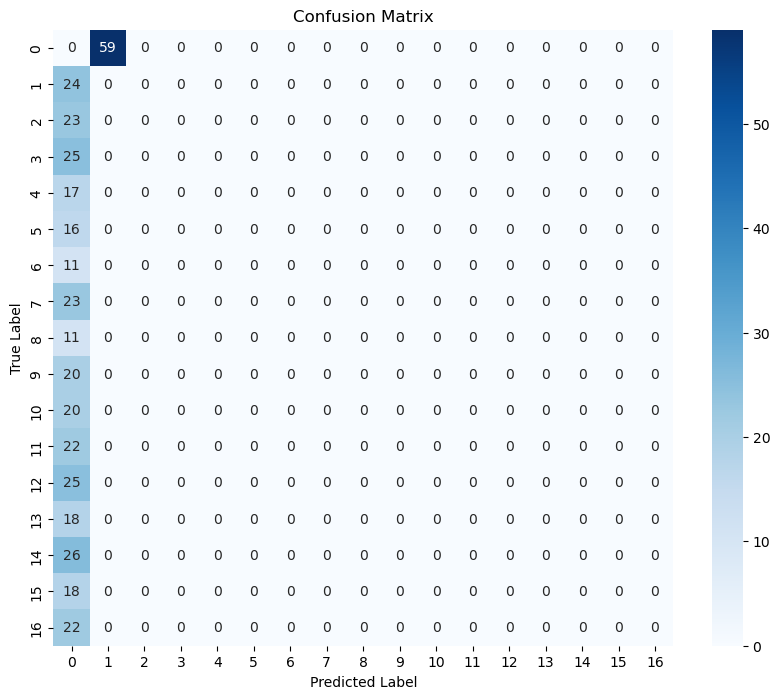

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Split data into training and validation sets (optional)
X_train, X_val, labels_train, labels_val = train_test_split(images, labels, test_size=0.2, random_state=42)

   # Ensure y_train is a 1D array (assuming class labels are in the first column of labels)
y_train = labels_train[:, 0]  # Select the first column if labels is 2D
   # Alternatively, if labels is a DataFrame: y_train = labels_train.iloc[:, 0]

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)


svm_model2 = load('svm_model2.joblib')

# Evaluate the model on the validation set (optional)
preds = svm_model2.predict(X_val_flat)
print(preds.shape)
# Convert one-hot encoded labels to categorical labels (if applicable)
y_p_classes = preds
if y_val.ndim == 1:
    y_val_class = np.argmax(y_val)
else:
    y_val_class = np.argmax(y_val, axis=1)  # Use axis=1 for 2D arrays


print("Confusion Matrix:")

# Compute confusion matrix
confusion_mat = confusion_matrix(y_val_class, y_p_classes)
print("Confusion Matrix:")
# print(confusion_mat)
   
    
# Visualize confusion matrix using box plot
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()    
